## RECONSTRUCTION

In [2]:
import AnalogToDigital as ADC
import AnalogToDigital.deltaSigma as deltaSigma

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from scipy import signal
import _pickle as pickle
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

import AnalogToDigital as ADC

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
n_samples = 10000     # number of sample pairs (x, y)
OSR = 32             # oversampling rate, must be integer
order = 2           # how many mash blocks
order_mash_block =2  # order of one mash block
n_lev = 2            # bit levels

/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/deltasigma/_realizeNTF.py:149: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = -np.real(np.linalg.lstsq(T.T, L1.T)[0]).T


<IPython.core.display.Javascript object>


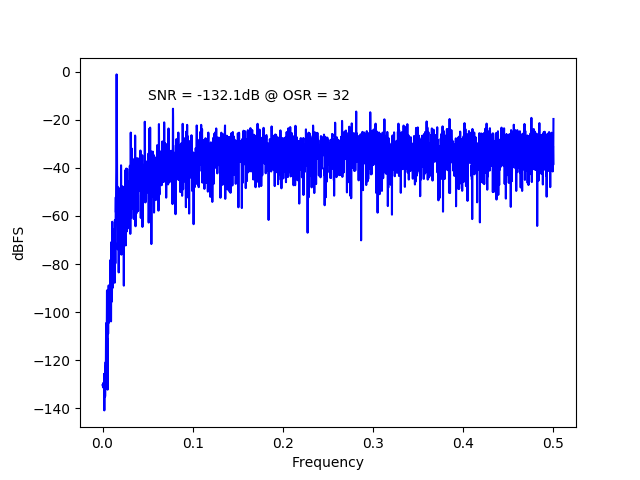

<IPython.core.display.Javascript object>


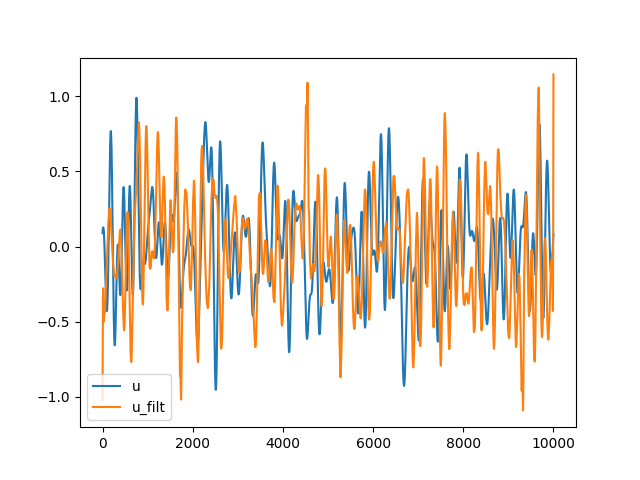

<IPython.core.display.Javascript object>


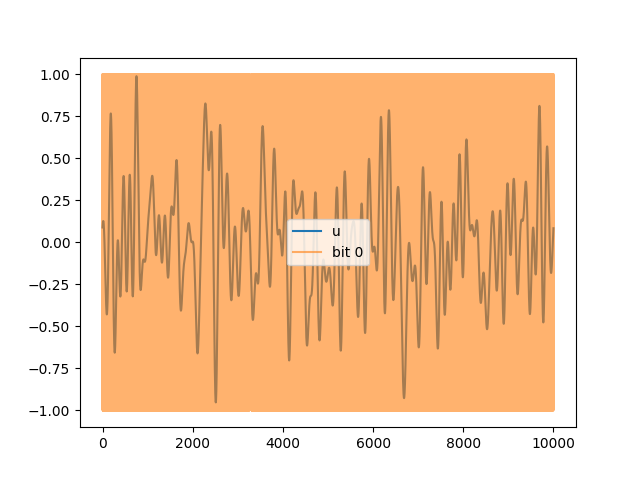

<IPython.core.display.Javascript object>


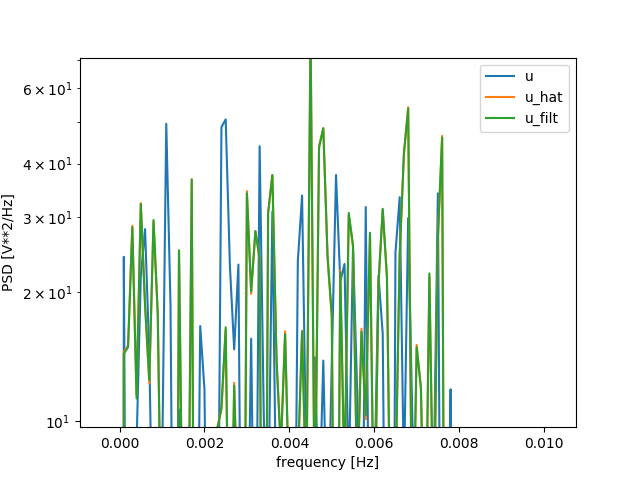

In [77]:
size = n_samples
fp = 500.
Ts = 1. / 2. / fp / OSR
scaling = (2 ** order)


dummy = np.zeros(order)
#input = ADC.system.Sin(Ts, 1, 1./Ts / 100 , 0, steeringVector=dummy)
input = ADC.system.BandlimitedNoise(1, 2 * OSR)

t = np.linspace(0., Ts * (size - 1) , size)
u = input.scalarFunction(t)
u = u - np.mean(u)

ds = [deltaSigma.DeltaSigma(OSR, order_mash_block, nlev = n_lev) for x in range(order)]
mash = deltaSigma.MASH(OSR, ds)
ds = deltaSigma.DeltaSigma(OSR, order, nlev = n_lev)


mash.simSpectrum()
bits = mash.simulate(input, t)

# mash.computeCancellationLogic(ds)
u_hat = mash.reconstruction(bits)
u_hat = ds.simulate(input, t)

# filter noise-shaped mash output signal
u_filt = u_hat.copy()
b, a = signal.iirfilter(4, 1./(OSR)*3, btype='lowpass', analog=False, ftype='butter')


n_filter_applied = 5
for ii in range(n_filter_applied):
    u_filt = signal.filtfilt(b, a, u_filt)


plt.figure()
plt.plot(u, label="u")
plt.plot(u_filt, label="u_filt")
plt.legend()

plt.figure()
plt.plot(u, label="u")
for ii in range(order):
    plt.plot(bits[:,ii], label = "bit %i" % ii, alpha=0.6)
    break
plt.legend()


plt.show()


# plot psd of input signal
f, psd_u = signal.periodogram(u, 1)
f, psd_u_hat = signal.periodogram(u_hat, 1)
f, psd_u_filt = signal.periodogram(u_filt, 1)


plt.figure()
plt.semilogy(f, psd_u, label='u')
plt.semilogy(f, psd_u_hat, label='u_hat')
plt.semilogy(f, psd_u_filt, label='u_filt')

plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()